<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# Search for Extra Terrestrial Intelligence (SETI)
###  SETI Signal Classification on PowerAI with Multi GPU
<hr>
<br>

### Introduction
In this Notebook, we will use the famous [SETI Dataset](https://github.com/setiQuest/ML4SETI/) to build a Convolutional Neural Networks capable to perform signals classification. CNN will say, with some associated error, what type of signal is the presented input. In this notebook, you will use IBM PowerAI with multiple GPU to train the model.

### Project overview:
Each night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals. The current signal detection system is programmed to search only for particular kinds of signals: narrow-band carrier waves. However, the detection system sometimes triggers on signals that are not narrow-band signals  (with unknown efficiency) and are also not explicitly-known radio frequency interference (RFI). There seems to be various categories of these kinds of events that have been observed in the past.

Our goal is to classify these accurately in real-time. This may allow the signal detection system to make better observational decisions, increase the efficiency of the nightly scans, and allow for explicit detection of these other signal types.

For more information refer to [SETI hackathon page](https://github.com/setiQuest/ML4SETI/).


Framing the radio signal data into spectrogram (a 2D visual representation), we can convert the problem into something akin to an image classification problem. CNN, will be run on the images which are the result of converting the signals to spectrogram.

### Training on Multi-GPU:
Today, many systems contains multiple GPUs for high performance computation. We can leverage this environments to run the training operation concurrently across multiple cards. One sample of these kind of environments is [IBM PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI). In this notebook, we show you how to design and run your model on multiple GPUs.





In [1]:
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from six.moves import urllib
import sys
import tarfile


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The directory '/home/nimbix/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/nimbix/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
  Running setup.py install for sklearn ... done


### Set the destination folder

In [2]:
### SET YOUR WORKING SPACE HERE! Use this folder to save intermediate results.
mydatafolder = "/tmp/SETI1_data"
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)
print mydatafolder

train_dir = '/tmp/SETI1_train'
if os.path.exists(train_dir) is False:
    os.makedirs(train_dir)
print train_dir

/tmp/SETI1_data
/tmp/SETI1_train


### Import dataset reader
The signals for this notebook, have been converted to spectogram images, and stored as 4 files.
The following cell will load a python code that help us to decode the binary file, and read the SETI dataset.

In [3]:
!wget -q --output-document  SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


### Download data
The dataset exist and shared on IBM box. Running the following cell, you can download the dataset and extract it.

In [4]:
def maybe_download_and_extract():
    data_dir = "/tmp/SETI1_data"
    DATA_URL =  'https://ibm.box.com/shared/static/qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz'
    dest_directory = data_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    extracted_dir_path = os.path.join(dest_directory, 'SETI_ds_64x128')
    if not os.path.exists(extracted_dir_path):
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

>> Downloading qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz 100.0%()
('Successfully downloaded', 'qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz', 2432541, 'bytes.')


### Load data SETI

In [5]:
ds_directory = mydatafolder + '/SETI_ds_64x128/'
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting /tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(694, 8192)

### Understanding the imported data

The imported data can be divided as follow:

- Training (dataset.train) >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "class1", this set will tell the neural network that we expect a "class1" as the output.  
        - 694 signals (images)
        - dataset.train.images for inputs
        - dataset.train.labels for outputs
  
  
- Test (mnist.test) >> the model does not have access to this informations prior to the test phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 10,000 data points
        - dataset.test.images for inputs
        - dataset.test.labels for outputs
        
        
#### Labels
- Each image (spectrum of signal) in the dataset has been labeled from 1 to 4, representing:
    - squiggle
    - narrowband
    - noise
    - narrowbanddrd

## Network Parameters

We place the parameters on CPU.   
__Notice:__ This code is not optimal for single-GPU training due to the cost of copying parameters between CPU and GPU.

In [6]:
# Parameters
decay_rate=0.96  #decay every 1000 steps with a base of 0.96:
decay_steps=1000
learning_rate = 0.005
training_epochs = 300
batch_size = 50
display_step = 100
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
use_fp16 = False

#check point directory
chk_directory = train_dir +'/save/'
checkpoint_path = chk_directory + 'model.ckpt'


NUM_CLASSES = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### How to use multi GPU for training?

PowerAI supports multi-GPU calculation.  Given multiple GPU cards, we run the SETI model on each GPU as following:

    1. Store all model parameters on the CPU.
    2. Put a copy of the SETI model on each GPU.
    3. Divide up a large batch of data across the GPUs, and feed each model replica with a unique batch of data.
    4. Compute the inference on each GPU
    5. Calculate the gradients on each GPU
    6. Wait until all GPUs finish processing of their batches
    7. Update model parameters synchronously on CPU

### Variable definitions

We define all variables using __tf.get_variable()__ in order to place the variables on CPU to be shares across multiple GPU for training. 

In [7]:
def _variable_on_cpu(name, shape, initializer):
    with tf.device('/cpu:0'):
        dtype = tf.float16 if use_fp16 else tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var

In [18]:
def _variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float16 if use_fp16 else tf.float32
    var = _variable_on_cpu(name, shape,tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

### Inference

This function builds the graph as far as required for running the network forward to make predictions.

In [9]:
def inference(images):

    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, 1, 32], stddev=0.1,  wd=0.0)
        conv = tf.nn.conv2d(images, kernel, strides=[1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [32], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, 32, 64],  stddev=0.1,  wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,  name='norm2')
    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME', name='pool2')
    
    
    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        reshape = tf.reshape(pool2, [batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = _variable_with_weight_decay('weights', shape=[dim, 1024], stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [1024], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[1024, 256],  stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [256], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
        #_activation_summary(local4)

    # linear layer(WX + b),
    # We don't apply softmax here because
    # tf.nn.sparse_softmax_cross_entropy_with_logits accepts the unscaled logits
    # and performs the softmax internally for efficiency.
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [256, NUM_CLASSES],  stddev=1/256.0, wd=0.0)
        biases = _variable_on_cpu('biases', [NUM_CLASSES], tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
    #_activation_summary(softmax_linear)

    return softmax_linear

#### Loss function
loss function, adds the ops required to generate loss, to the inference graph. It calculates the average cross entropy loss across the batch.  

The total loss in calc_loss is defined as the cross entropy loss plus all of the weight decay terms (L2 loss).

In [25]:
def calc_loss(logits, labels):
    """Add L2Loss to all the trainable variables."""
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

As we want to run the CNN on multiple GPUs, we construct our model in a multi-tower fashion where each tower is assigned to a different GPU. The following function calculate the loss value for each tower.

In [11]:
# Calculate the total loss on a single tower running the SETI model.
def tower_loss(scope, images, labels):
    # Build inference Graph.
    logits = inference(images)
    _=calc_loss(logits, labels)

    # Assemble all of the losses for the current tower only.
    # 'losses' is the key for collection
    # scope is for e.g. 'tower_0'
    losses = tf.get_collection('losses', scope)

    # Calculate the total loss for the current tower.
    total_loss = tf.add_n(losses, name='total_loss')

    return total_loss

#### Gradients
  """Calculate the average gradient for each shared variable across all towers.

  Note that this function provides a synchronization point across all towers.

  Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
  Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
  """

In [12]:
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
    # Note that each grad_and_vars looks like the following:
    #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

#### Training


In [13]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
# Decay the learning rate exponentially based on the number of steps.
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )


In [14]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
optimizer = tf.train.GradientDescentOptimizer(lr)

# Calculate the gradients for the batch of data on this SETI tower.
#grads = opt.compute_gradients(loss)

#train_op = optimizer.minimize(loss, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [15]:
# Get images and labels for SETI.
x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
x_image = tf.reshape(x_batch, [-1,height,width,1]) 
labels = tf.reshape(y_batch,[-1,NUM_CLASSES])

In [16]:
# with tf.Session() as sess:
#     with tf.name_scope("test12"):
#         logit1 = inference(x_image)

In [19]:
# Calculate the gradients for each model tower.
tower_grads = []
with tf.variable_scope(tf.get_variable_scope()):
    for i in xrange(4):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('%s_%d' % ('tower_', i)) as scope:
                # read one batch for the GPU
                x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
                image_batch = tf.reshape(x_batch, [-1,height,width,1]) 
                #label_batch = tf.reshape(y_batch,[-1,NUM_CLASSES])
                # Calculate the loss for one tower of the SETI model. This function
                # constructs the entire SETI model but shares the variables across
                # all towers.
                loss = tower_loss(scope, image_batch, y_batch)
                # Reuse variables for the next tower.
                tf.get_variable_scope().reuse_variables()
                grads = optimizer.compute_gradients(loss)
                tower_grads.append(grads)
# on CPU                
grads = average_gradients(tower_grads)
# Apply the gradients to adjust the shared variables.
apply_gradient_op = optimizer.apply_gradients(grads, global_step=global_step)

# Track the moving averages of all trainable variables.
variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

# Group all updates to into a single train op.
# we call train_op in learning process
# tf.group Creates an op that groups multiple operations.
# When this op finishes, all ops in input have finished. This op has no output.
train_op = tf.group(apply_gradient_op, variables_averages_op)

#### Evaluation

### Create checkpoint directory

In [20]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

## Training

In [21]:
# Initializing the variables
init = tf.global_variables_initializer()

In [22]:
loss_values = []

X_test = dataset.test.images
y_test = dataset.test.labels

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)
saver = tf.train.Saver(tf.global_variables())

# load previously trained model if appilcable
ckpt = tf.train.get_checkpoint_state(chk_directory)
if ckpt:
    print "loading model: ",ckpt.model_checkpoint_path
    #saver.restore(sess, ckpt.model_checkpoint_path)

    


In [23]:
#step = 0
num_examples = dataset.train.num_examples
num_examples

694

In [24]:
# Training cycle
t_start = time.time()
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_accuracy = 0.
    #dataset.shuffle_data()
    total_batch = int(num_examples / batch_size)

    # Loop over all batches in one epoch
    start = time.time()
    for step in range(total_batch):
        _, loss_value = sess.run([train_op, loss])
        assert not np.isnan(loss_value), 'Model diverged with loss = NaN'
    end = time.time()    
    # Display model every 1 epochs
    if epoch >= 0 and epoch % 10 == 0:
        plr = sess.run(lr)
        g_step = sess.run(global_step)
        loss_values.append(loss_value)
        print "Epoch:", '%04d' % (epoch+1) , ", g_step:", '%04d' % (g_step) , ", E_time=" , "{:.5f}".format(end - start) , ", lr=", "{:.9f}".format(plr), ", cost=", "{:.9f}".format(loss_value)
t_end = time.time()
print("Wall Time:","{:.1f}".format(t_end - t_start), "sec")
print("Optimization Finished!")
print ("model saved to {}".format(checkpoint_path))
saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)

Epoch: 0001 , g_step: 0013 , E_time= 16.99464 , lr= 0.005000000 , cost= 22.792268753
Epoch: 0011 , g_step: 0143 , E_time= 0.46558 , lr= 0.005000000 , cost= 22.620203018
Epoch: 0021 , g_step: 0273 , E_time= 0.45872 , lr= 0.005000000 , cost= 22.238647461
Epoch: 0031 , g_step: 0403 , E_time= 0.45459 , lr= 0.005000000 , cost= 22.043088913
Epoch: 0041 , g_step: 0533 , E_time= 0.45677 , lr= 0.005000000 , cost= 21.919942856
Epoch: 0051 , g_step: 0663 , E_time= 0.46048 , lr= 0.005000000 , cost= 21.805158615
Epoch: 0061 , g_step: 0793 , E_time= 0.46224 , lr= 0.005000000 , cost= 21.692844391
Epoch: 0071 , g_step: 0923 , E_time= 0.46246 , lr= 0.005000000 , cost= 21.581773758
Epoch: 0081 , g_step: 1053 , E_time= 0.47043 , lr= 0.004800000 , cost= 21.473638535
Epoch: 0091 , g_step: 1183 , E_time= 0.45431 , lr= 0.004800000 , cost= 21.368890762
Epoch: 0101 , g_step: 1313 , E_time= 0.44924 , lr= 0.004800000 , cost= 21.265052795
Epoch: 0111 , g_step: 1443 , E_time= 0.46565 , lr= 0.004800000 , cost= 21.1

'/tmp/SETI1_train/save/model.ckpt-3600'

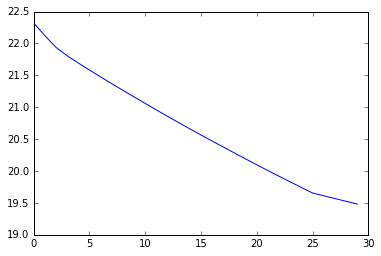

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()


## Want to learn more?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI).

### Authors

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://ibm.box.com/shared/static/tyd41rlrnmfrrk78jx521eb73fljwvv0.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is Sr. Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

